In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.init as init
from torch.autograd import Variable
import os
from matplotlib.pyplot import GridSpec
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
os.chdir('..')

import argparse
import numpy as np
from PIL import Image
from utils.dataloader import *
from utils.auc import *
from utils import new_transforms
%matplotlib inline

In [2]:
root_dir = "/beegfs/jmw784/Capstone/LungTilesSorted/"
num_classes = 3
tile_dict_path = '/beegfs/jmw784/Capstone/Lung_FileMappingDict.p'
imgSize = 299

In [3]:
transform = transforms.Compose([new_transforms.Resize((imgSize,imgSize)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = TissueData(root_dir, 'test', transform = transform, metadata=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
classes = test_data.classes

In [5]:
def get_tile_probability(tile_path):

    """
    Returns an array of probabilities for each class given a tile

    @param tile_path: Filepath to the tile
    @return: A ndarray of class probabilities for that tile
    """

    # Some tiles are empty with no path, return nan
    if tile_path == '':
        return np.full(num_classes, np.nan)

    tile_path = root_dir + tile_path

    with open(tile_path, 'rb') as f:
        with Image.open(f) as img:
            img = img.convert('RGB')

    # Model expects a 4D tensor, unsqueeze first dimension
    img = transform(img).unsqueeze(0)

    # Turn output into probabilities with softmax
    var_img = Variable(img, volatile=True)
    output = F.softmax(model(var_img)).data.squeeze(0)

    return output.numpy()

In [6]:
with open(tile_dict_path, 'rb') as f:
    tile_dict = pickle.load(f)

In [7]:
def aggregate(file_list, method):

    """
    Given a list of files, return scores for each class according to the
    method and labels for those files.

    @param file_list: A list of file paths to do predictions on
    @param method: 'average' - returns the average probability score across
                               all tiles for that file
                   'max' - predicts each tile to be the class of the maximum
                           score, and returns the proportion of tiles for
                           each class

    @return: a ndarray of class probabilities for all files in the list
             a ndarray of the labels

    """

    model.eval()
    predictions = []
    true_labels = []

    for file in file_list:
        tile_paths, label = tile_dict[file]

        folder = classes[label]

        def add_folder(tile_path):
            if tile_path == '':
                return ''
            else:
                return folder + '/' + tile_path

        # Add the folder for the class name in front
        add_folder_v = np.vectorize(add_folder)
        tile_paths = add_folder_v(tile_paths)

        # Get the probability array for the file
        prob_v = np.vectorize(get_tile_probability, otypes=[np.ndarray])
        probabilities = prob_v(tile_paths)


        """
        imgSize = probabilities.shape()
        newShape = (imgSize[0], imgSize[1], 3)
        probabilities = np.reshape(np.stack(probabilities.flat), newShape)
        """

        if method == 'average':
            probabilities = np.stack(probabilities.flat)
            prediction = np.nanmean(probabilities, axis = 0)

        elif method == 'max':
            probabilities = np.stack(probabilities.flat)
            probabilities = probabilities[~np.isnan(probabilities).all(axis=1)]
            votes = np.nanargmax(probabilities, axis=1)
            
            out = np.array([sum(votes == i) for i in range(num_classes)])
            prediction = out / out.sum()

        else:
            raise ValueError('Method not valid')

        predictions.append(prediction)
        true_labels.append(label)

    return np.array(predictions), np.array(true_labels)

In [8]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, pool, **kwargs):
        super(BasicConv2d, self).__init__()

        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.conv(x)

        if self.pool:
            x = F.max_pool2d(x, 2)
        
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        return x

# Define model
class cancer_CNN(nn.Module):
    def __init__(self, nc, imgSize, ngpu):
        super(cancer_CNN, self).__init__()
        self.nc = nc
        self.imgSize = imgSize
        self.ngpu = ngpu
        self.data = 'lung'
        self.conv1 = BasicConv2d(nc, 16, False, kernel_size=5, padding=1, stride=2, bias=True)
        self.conv2 = BasicConv2d(16, 32, False, kernel_size=3, bias=True)
        self.conv3 = BasicConv2d(32, 64, True, kernel_size=3, padding=1, bias=True)
        self.conv4 = BasicConv2d(64, 64, True, kernel_size=3, padding=1, bias=True)
        self.conv5 = BasicConv2d(64, 128, True, kernel_size=3, padding=1, bias=True)
        self.conv6 = BasicConv2d(128, 64, True, kernel_size=3, padding=1, bias=True)
        self.linear = nn.Linear(5184, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [9]:
model = cancer_CNN(3, imgSize, 1)

In [10]:
model_path = "/scratch/jmw784/capstone/Charrrrtreuse/experiments/joy15/epoch_10.pth"
state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict)

In [11]:
len(test_data.filenames)

296

In [ ]:
predictions, labels = aggregate(test_data.filenames, method='max')
roc_auc = get_auc('experiments/15/images/test_AUC.jpg',
                  predictions, labels, classes = range(num_classes))

In [12]:
files = tile_dict[test_data.filenames[0]][0]

In [14]:
files.shape

(23, 31)

In [104]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
def shift_hue(arr,hout):
    hsv=rgb_to_hsv(arr)
    hsv[:,:,0]=hout
    rgb=hsv_to_rgb(hsv)*255
    return rgb

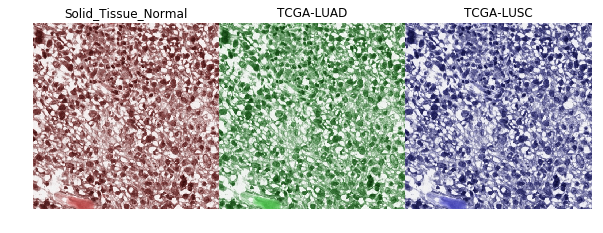

In [146]:
filename = tile_dict[slide][0][10, 10]
label =  classes[tile_dict[slide][1]]
img = pil_loader(root_dir + '/' + label + '/' + filename)
img = np.array(img)

gs = GridSpec(1, 3, wspace=0, hspace=0)

plt.figure(figsize=(10, 8))
for i in range(3):
    ax = plt.subplot(gs[0, i])
    hue = i/3
    shifted = shift_hue(img, hue)
    plt.imshow(shifted)
    plt.axis('off')
    plt.title('%s' % (classes[i]))

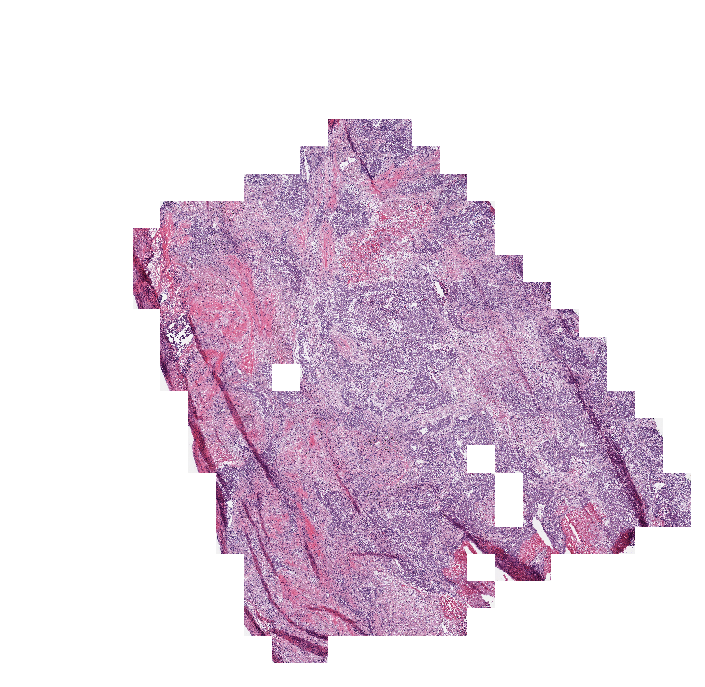

In [152]:
slide = test_data.filenames[1]
rows, columns = tile_dict[slide][0].shape
length = 0.5

height = length * rows
width = length * columns

plt.figure(figsize=(width, height))
gs = GridSpec(rows, columns, wspace=0, hspace=0)

for i in range(rows):
    for j in range(columns):
        ax = plt.subplot(gs[i, j])
        
        filename = tile_dict[slide][0][i, j]
        label =  classes[tile_dict[slide][1]]
        
        if filename != '': 
            img = pil_loader(root_dir + '/' + label + '/' + filename)
            plt.imshow(img)
            
        plt.axis('off')
        ax.grid(False)

In [ ]:
model.eval()

slide = test_data.filenames[1]
rows, columns = tile_dict[slide][0].shape

length = 0.5

height = length * rows
width = length * columns

plt.figure(figsize=(width, height))
gs = GridSpec(rows, columns, wspace=0, hspace=0)

label =  classes[tile_dict[slide][1]]

for i in range(rows):
    for j in range(columns):
        ax = plt.subplot(gs[i, j])
        
        filename = tile_dict[slide][0][i, j]
        
        if filename != '': 
            img = pil_loader(root_dir + '/' + label + '/' + filename)
            var_img = Variable(transform(img).unsqueeze(0), volatile=True)
            probs = F.softmax(model(var_img)).data.squeeze(0).numpy()
            
            prediction, prob = np.argmax(probs), np.max(probs)
            
            img = np.array(img)
            hue = prediction/3
            
            img = shift_hue(img, hue)
            plt.imshow(img, alpha = prob)
            
        plt.axis('off')
        ax.grid(False)
        
plt.title('True label: %s' % (label))